**Andrew Wang's Data Science 100 Project Proposal**

*Introduction*:  
Heart disease is a serious medical condition that can drastically alter an individual's life. It is important for both data analysts and medical professionals to be able to predict when someone is at risk of developing heart disease as this can lead to immediate lifestyle adjustments/medical attention that can help people live longer. The database I will be analyzing is a collection of variables such as age, sex, and cholesterol from a study on heart disease conducted by Andras Janosi, William Steinburnn, Matthias Pfisterer, and Robert Detrano. The data used in this project will be obtained from the processed data of Hungarian (Janosi). The purpose of this project and using this database is to answer the following question:  
**"Is it possible to accurately diagnose heart disease based solely on an individual's resting blood pressure and serum cholesterol?"**  
This is a classification problem where in this project, I am going to be building a model that will take in two variables: an individuals resting blood pressure and amount of serum cholesterol and try to predict whether or not this individual will have heart disease.      

*Preliminary exploratory data analysis:*  
The first step in answering my question is to identify the necessary libraries required to complete the data analysis. The following libraries below are going to be used in this project.

In [26]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Next we need to read the data into R. This can be done using the read_csv function as the delim of the data file is a comma. We must also specify in the read_csv function that the data itself does not contain column names.

In [27]:
data <- read_csv("data/heart_disease/processed.hungarian.data", col_names = FALSE)
print("Figure 1: Raw Data")
data

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Figure 1: Raw Data"


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,2,?,?,1
58,0,2,180,393,0,0,110,1,1,2,?,7,1
65,1,4,130,275,0,1,115,1,1,2,?,?,1


We have successfully loaded the data into R, but it is not in a tidy format. We must clean and wrangle the data to make it visually appearing and easier to work with.

In [28]:
data <- data |>
        rename(resting_blood_pressure = X4, cholestoral = X5, heart_disease = X14)


In [29]:
data <- select(data, resting_blood_pressure, cholestoral, heart_disease) |>
        filter(resting_blood_pressure != "?") |>
        filter(cholestoral != "?") |>
        filter(heart_disease != "?")

In [30]:
data <- data %>%
        mutate(heart_disease = case_when(
            heart_disease == 0 ~ 0,
            heart_disease %in% c(1, 2, 3, 4) ~ 1
            ))

In [31]:
data <- mutate(data, resting_blood_pressure = as.double(resting_blood_pressure)) 
data <- mutate(data, cholestoral = as.double(cholestoral))
data <- mutate(data, heart_disease = as.factor(heart_disease))
print("Figure 2: Tidy Data")
data

[1] "Figure 2: Tidy Data"


resting_blood_pressure,cholestoral,heart_disease
<dbl>,<dbl>,<fct>
130,132,0
120,243,0
170,237,0
⋮,⋮,⋮
155,342,1
180,393,1
130,275,1


We have selected the columns we are going to be using and changed them to double, added column names, removed missing values, and changed the heart_disease to contain only values of 0 and 1 where 0 represents no heart disease and 1 is any degree of heart disease. Now the data must be split into 2 sections: one for training the model and one for testing the model. The set.seed() function will be used here to ensure that the data we obtained will be consistent through every iteration so the process can be replicated consistently. 

In [32]:
set.seed(573)
data_split <- initial_split(data, prop = 0.75, strata = heart_disease)
data_train <- training(data_split)
data_test <- testing(data_split)

In [33]:
summary_data_mean <- data_train |>
        summarize(average_rbp = mean(resting_blood_pressure), average_cholestoral = mean(cholestoral))
summary_data_count <- data_train |>
                      summarize(number_of_heart_disease = nrow(filter(data_train, heart_disease == 1)))
print("Figure 3: Number of Heart Disease")
summary_data_count
print("Figure 4: Average Resting Blood Pressure and Cholestoral")
summary_data_mean

[1] "Figure 3: Number of Heart Disease"


number_of_heart_disease
<int>
75


[1] "Figure 4: Average Resting Blood Pressure and Cholestoral"


average_rbp,average_cholestoral
<dbl>,<dbl>
132.6567,249.393


Here we can see the number of cases where the patient was identified to have heart disease, and the average resting blood pressure and average cholestoral of the entire dataset.

[1] "Figure 5: Plot of Resting Blood Pressure and Serum Cholestoral (Training Data)"


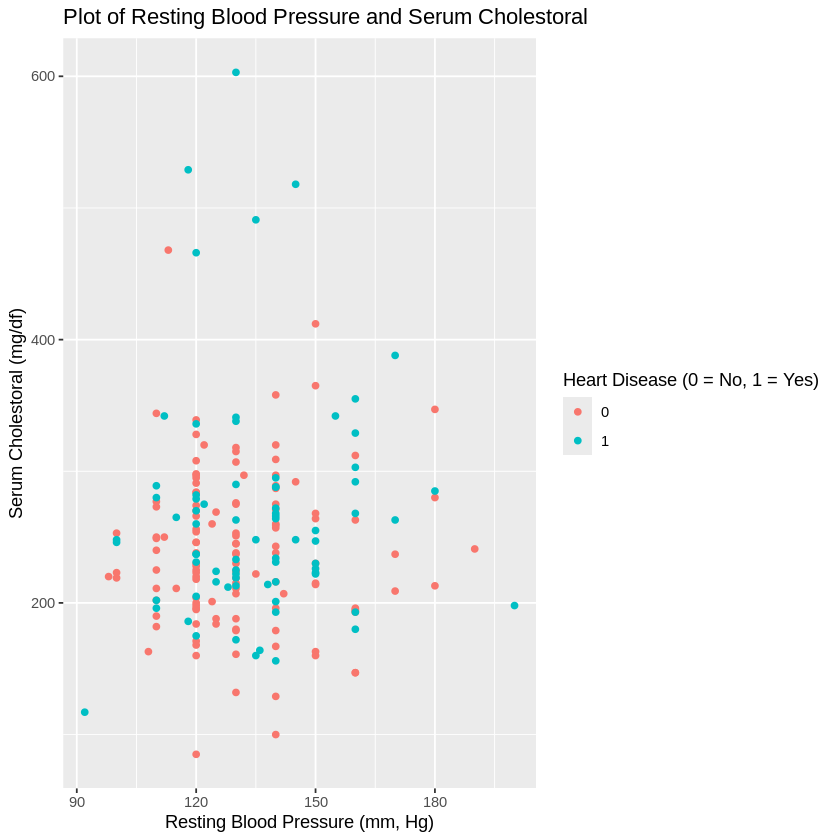

In [34]:
training_plot <- data_train |>
                 ggplot(aes(x = resting_blood_pressure, y = cholestoral, color = heart_disease)) +
                 geom_point() +
                 labs(x = "Resting Blood Pressure (mm, Hg)", y = "Serum Cholestoral (mg/df)", color = "Heart Disease (0 = No, 1 = Yes)") +
                 ggtitle("Plot of Resting Blood Pressure and Serum Cholestoral")
print("Figure 5: Plot of Resting Blood Pressure and Serum Cholestoral (Training Data)")
training_plot

*Methods:* 

The first step that must be done before building the model is to standardize the variables. Just by looking at the plot above, it is clear that the cholestoral levels have a much higher variance than resting blood pressure. If we were to not standardize the variables, the K-nearest-neighbor algorithm will choose a data point's neighbour based primarily on cholestoral level, rather than prioritizing both cholestoral and resting blood pressure equally. This leads to incorrect predictions being made by the model which is what we do not want. The next steps would be to find the most ideal K value that has the highest accuracy percentage, and then to build a recipe and model using the K value obtained. Finally, it would all be added into a workflow where we can test it using the testing set we had previously created. One way to visualize the results would be two side-by-side scatter plots where one plot is the actual values of heart_disease and the other is the predicited value. This side-by-side comparison allows for easy analysis on whether the model predicted well or not.  

*Expected outcome and significance:*  

I predict that the model will have a low accuracy rate and be quite inaccurate. By looking at the plot above, it seems like there is no clear distinction between resting blood presure and cholestoral, making it hard for the model to classify based on the surrounding neighbors. The impact of this result, whatever it might entail, would tell those in the medical field what variables are actually important in dictating whether a patient has heart disease or not. If the model is inaccurate, a future question could be what other variables are necessary to consider when diagnosing heart disease.


*Data Analysis:*  
When using the k-nearest-neighbor algorithm, the most important step of using this algorithm is to determine the best value of K that will give us the most accuracte predictions. This will be done by performing cross-validation. Cross-validation is a common technique in machine learning and in this context, it is necessary in finding the best possible k value. This is done by creating "folds" within the data and training it multiple times with a different value of k each time. Through repetition and trail and error, the best k value will be discovered (Brownlee). 

In [35]:
set.seed(573)
data_recipe <- recipe(heart_disease ~ resting_blood_pressure + cholestoral, data = data_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())
data_vfold <- vfold_cv(data_train, v = 5, strata = heart_disease)
data_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")
neighbors <- tibble(neighbors = seq(from = 1, to = 10, by = 1))
data_results <- workflow() |>
                add_recipe(data_recipe) |>
                add_model(data_tune) |>
                tune_grid(resamples = data_vfold, grid = neighbors) |>
                collect_metrics()
print("Figure 6: Data Results")
data_results

[1] "Figure 6: Data Results"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5773171,5,0.02115282,Preprocessor1_Model01
1,roc_auc,binary,0.5523590,5,0.02821636,Preprocessor1_Model01
2,accuracy,binary,0.5773171,5,0.02258190,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,binary,0.5264205,5,0.04637114,Preprocessor1_Model09
10,accuracy,binary,0.5818293,5,0.02513970,Preprocessor1_Model10
10,roc_auc,binary,0.5276821,5,0.04429480,Preprocessor1_Model10


[1] "Figure 7: Best K Plot"


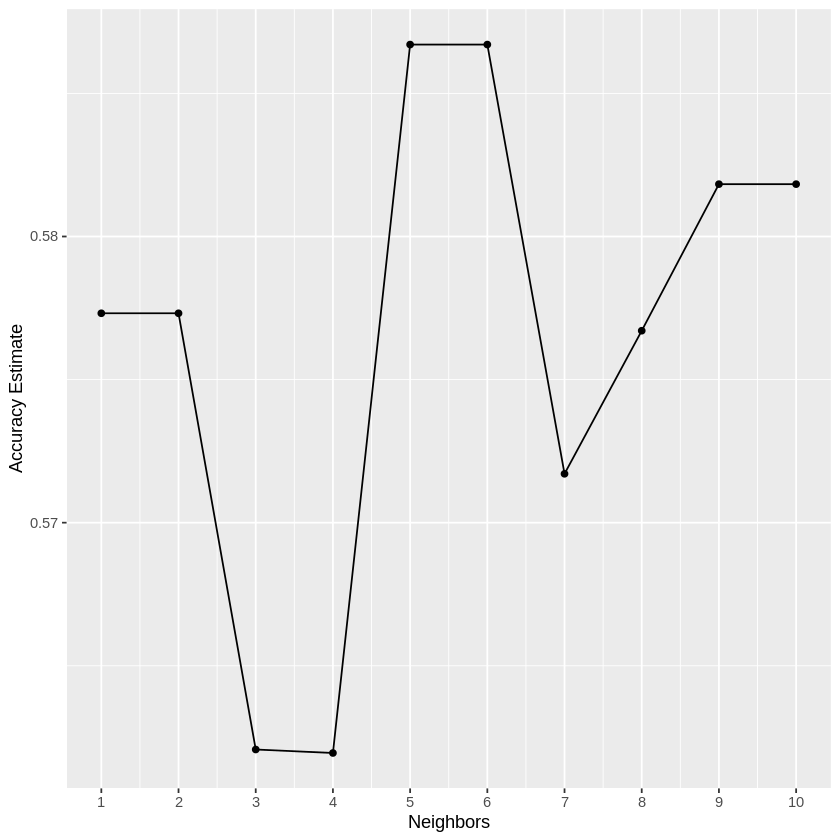

In [36]:
accuracy <- data_results |>
            filter(.metric == "accuracy")
best_k_plot <- accuracy |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "Neighbors", y = "Accuracy Estimate") + 
                scale_x_continuous(breaks = seq(0, 10, by = 1)) 
print("Figure 7: Best K Plot")
best_k_plot

As we can see from our analysis, the k values that will produce the highest degree of accuracy will be k = 5 or 6. Another important detail to note regarding this plot is that it lacks consistency. The accuracy of a k value seems random, there is no gradual decrease as we increase/decrease the k value. This was expected as given our plot of the variables, I had noted that it would be hard to classify a data point purely on its neighbours using these two variables. Now we must build the actual model using a k value of 6. We will reuse our recipe but will need to adjust the classifier and train it accordingly. 

In [37]:
best_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
                 set_engine("kknn") |>
                 set_mode("classification") 
best_fit <- workflow() |>
            add_recipe(data_recipe) |>
            add_model(best_knn_spec) |>
            fit(data = data_train)

After creating the K-nearest neighbor classifier object, it can be tested using our testing data to see the accuracy of the model.

In [38]:
data_test_predictions <- predict(best_fit, data_test) |>
                         bind_cols(data_test)
print("Figure 8: Data Test Predictions")
data_test_predictions

[1] "Figure 8: Data Test Predictions"


.pred_class,resting_blood_pressure,cholestoral,heart_disease
<fct>,<dbl>,<dbl>,<fct>
0,120,243,0
0,105,198,0
0,125,254,0
⋮,⋮,⋮,⋮
0,130,294,1
1,180,393,1
0,130,275,1


This table does not tell us much regarding the accuracy of the classifier. Thankfully, we can use the metrics function to collect information regarding accuracy and create a confusion matrix to get a better understanding of our classifier.

In [39]:
data_prediction_accuracy <- data_test_predictions |>
                            metrics(truth = heart_disease, estimate = .pred_class)
print("Figure 9: Classifier Accuracy")
data_prediction_accuracy

[1] "Figure 9: Classifier Accuracy"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.57971014
kap,binary,0.05479452


In [40]:
data_confusion <- data_test_predictions |>
                  conf_mat(truth = heart_disease, estimate = .pred_class)
print("Figure 10: Confusion Matrix")
data_confusion

[1] "Figure 10: Confusion Matrix"


          Truth
Prediction  0  1
         0 32 18
         1 11  8

[1] "Figure 11: Prediction Plot of Heart Disease Cases vs Actual Cases of Heart Disease Plot"


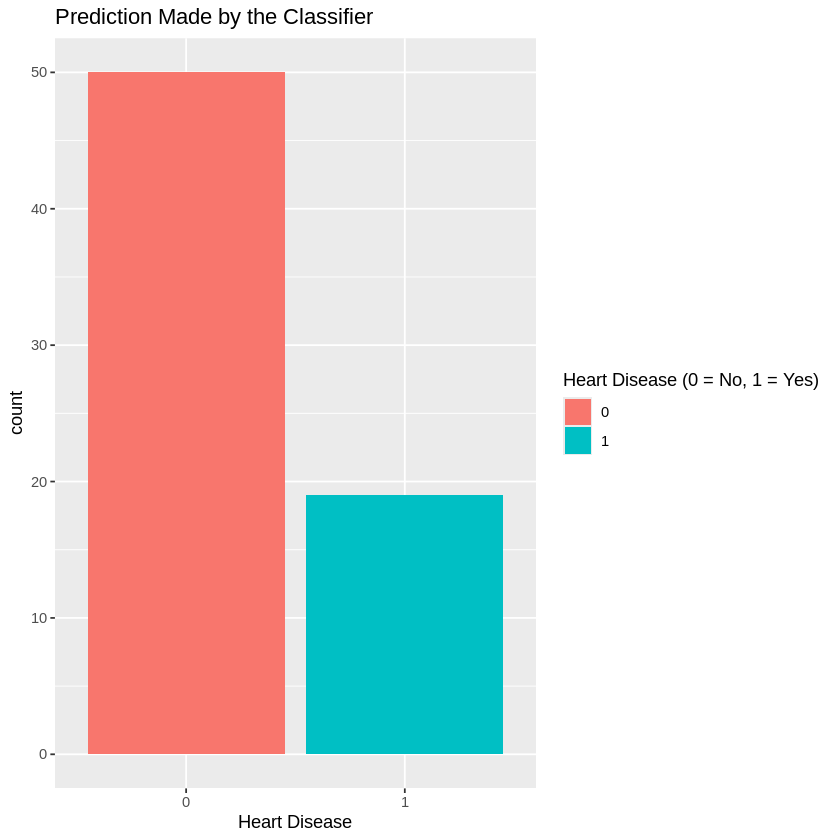

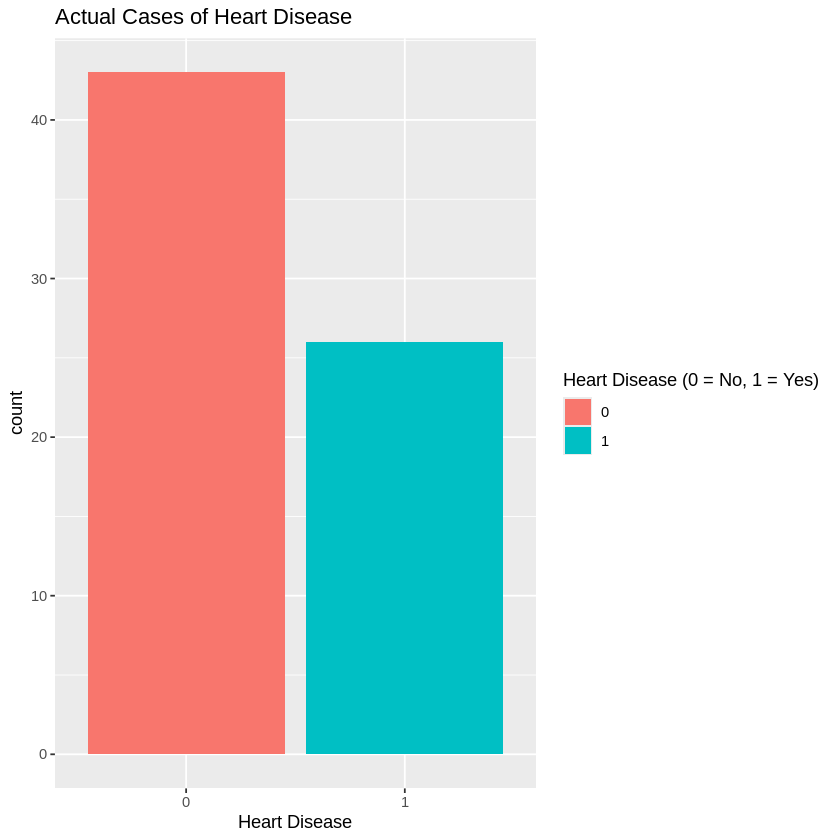

In [51]:
prediction_plot <- data_test_predictions |>
                    ggplot(aes(x = .pred_class, fill = .pred_class)) +
                    geom_bar() +
                    labs(fill = "Heart Disease (0 = No, 1 = Yes)", x = "Heart Disease") +
                    ggtitle("Prediction Made by the Classifier")
actual_plot <- data_test_predictions |>
                ggplot(aes(x = heart_disease, fill = heart_disease)) +
                geom_bar() +
                labs(fill = "Heart Disease (0 = No, 1 = Yes)", x = "Heart Disease") +
                ggtitle("Actual Cases of Heart Disease")
print("Figure 11: Prediction Plot of Heart Disease Cases vs Actual Cases of Heart Disease Plot")
prediction_plot
actual_plot

*Discussion:*  
Looking at these two plots, it is immediately clear that the classifier struggled to identify real cases of heart disease and incorrectly classified patients to not have heart disease. Just looking at these plots visually, the belief that the classifier is quite accurate can be made as the two plots look visually quite similar. But it is important to recognize that just because the two plots are similar does not mean the classifier is predicting majority of these cases correctly. This is a limitation of using a bar graph to represent out analysis as lets use an example of two patients, one who has heart disease and another who does not. The classifier could have predicted for the one who actually has heart disease to not have it, and the one who does not to have it. Even though the distribution for the prediction vs actual case plot would be identical, the accuracy would be 0. For further analysis on the classifier, we have to look at Figure 9 and 10.   

As we can see, the classifier has made quite a bit of mistakes and only has an accuracy of approximately 58%. Doing some basic math, the classifier has a recall of approximately 0.31, meaning the classifier is able to correctly identify 31% of the patients who are actually diagnosed with heart disease. This is an extremely low magnitude as it is fairly inaccurate at detecting actual heart disease, true positive, missing 69% of patients who actually have heart disease (false negatives). In this context, it is simply not acceptable to use this model in a practical setting as this would mean approximately seven out of 10 people will be under the false pretense that they and their lifestyles are healthy when in reality they currently are experiencing a deadly condition. The classifier also has a precision of 0.42, meaning 42% of the patients are identified correctly as having heart disease, while the remaining 58% are misdiagnosed with heart disease (false positives). This forces the misdiagnosed patients to undergo treatment that they do not need, harming their bodies for unnecessary reasons. Once again, this shows that this classifier is not suitable to be making predictions within the context of diagnosing patients with heart disease.

The results aligned with what I initially expected to happen. With how close together the data points are with no regard to its class, it is extremely hard for the classifier to produce accurate predictions. This was also shown when trying to identify the best k value when building the classifier. The question I set out to answer when starting this report was: **"Is it possible to accurately diagnose heart disease based solely on an individual's resting blood pressure and serum cholesterol?"**. And now I can confidently claim that it is not possible to accurately diagnose heart disease based solely on blood pressure and cholestoral. This indicates that other variables have to be considered before diagnosing a patient with heart disease. The question is specifically what variables was I missing to create an accurate classifier? According to online sources, lots of other factors need to be considered as well. Some factors that the dataset also includes are age as the older you get the higher risk you have of getting heart disease, sex as woman are more susceptible to varying types of heart disease, etc (Heart and Stroke Foundation of Canada). However, other factors need to be considered that simply cannot be quantified such as family/medical history or levels of stress. This hints at the idea that it is not possible to build a classifier that is extremely accurate at diagnosing patients with heart disease. There are simply too many factors that need to be considered and a machine is incapable of taking some of these factors into consideration. If I were to do this again, I would choose a wider range of variables to determine what is the highest degree of accuracy that a classifier can possible obtain with the given variables and information. 


*References:*  
Brownlee, Jason. “A Gentle Introduction to K-Fold Cross-Validation.” Machine Learning Mastery, 4 Oct. 2023, machinelearningmastery.com/k-fold-cross-validation/. Accessed June 2024.  
Heart and Stroke Foundation of Canada.“Types of Heart Disease.” Heart and Stroke Foundation of Canada, www.heartandstroke.ca/heart-disease/what-is-heart-disease/types-of-heart-disease. Accessed June 2024.  
Janosi, Andras, et al. “Heart Disease.” Archive.ics.uci.edu, 1988. Heart Disease, archive.ics.uci.edu/dataset/45/heart+disease. Accessed June 2024.